Generate final manuscript figures.

In [1]:
%load_ext autoreload
%autoreload 2

import os

import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import wandb
import xarray as xr

from functools import partial
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt

from fme_diags.bias import (
    compute_time_mean_bias, plot_time_mean_bias,
    plot_time_mean_bias_list
)
from fme_diags.histogram import compute_histograms, plot_time_mean_histogram
from fme_diags.tropics.tropics import (
    compute_wavenumber_frequency_spectra, 
    plot_wavenumber_frequency_spectra
)
from fme_diags.utils import (
    get_run_kwargs, get_wandb_path,
    load_config, load_global_time_mean_metrics, 
    open_autoregressive_inference, open_reference,
)

_ = xr.set_options(keep_attrs=True)

## Get config, define constants, make output plots directory, and open datasets

In [2]:
if not "RUN_KEY" in os.environ:
    RUN_KEY = "42yrs-batch_size8-max_epochs50-lr3e-4-run4"
    REF_KEY = "42-years-training-set-reference"
else:
    RUN_KEY = os.environ["RUN_KEY"]
    REF_KEY = os.environ["REFERENCE_KEY"]
    
FV3GFS_KEY = "with-hgt-sfc-frac-august-10yr"
    
print(f"Run key: {RUN_KEY}")
print(f"Reference key: {REF_KEY}")
print(f"FV3GFS key: {FV3GFS_KEY}")

Run key: 42yrs-batch_size8-max_epochs50-lr3e-4-run4
Reference key: 42-years-training-set-reference
FV3GFS key: with-hgt-sfc-frac-august-10yr


In [3]:
config = load_config("./preds.yaml")
run_kwargs = get_run_kwargs(config, RUN_KEY)

if run_kwargs["flip_lat"]:
    WK_LAT_BOUNDS = (-15, 15)
else:
    WK_LAT_BOUNDS = (15, -15)

WK_SEG_SIZE = 128
    
PRECIP = "surface_precipitation_rate"
PS = "PS"
OLR = "FLUT"
OSR = "top_of_atmos_upward_shortwave_flux"  
TWP_ADV = "tendency_of_total_water_path_due_to_advection"

PS_FACTOR = 0.01 
PS_UNITS = "hPa"

PRECIP_FACTOR = 86400.0
PRECIP_UNITS = "mm/day"

FLUX_UNITS = "W/m$^2$"
    
run_kwargs

{'path': '/pscratch/sd/j/jpduncan/ai2/datasets/2023-11-22-e3smv2-vertically-resolved-1deg-fme-dataset/output/42-years-training-set/42yrs-batch_size8-max_epochs50-lr3e-4-run4/autoregressive_predictions.nc',
 'start': '0054-01-01',
 'step_dim': 'lead',
 'step_freq': '6H',
 'calendar': 'noleap',
 'flip_lat': False,
 'chunks': {'lead': 178}}

In [4]:
OUTDIR = f"figs/{RUN_KEY}"
os.makedirs(OUTDIR, exist_ok=True)

In [5]:
ds = open_autoregressive_inference(**run_kwargs)
ds

<xarray.Dataset>
Dimensions:                                        (time: 14597, sample: 1,
                                                    source: 2, lat: 180,
                                                    lon: 360)
Coordinates:
  * time                                           (time) object 0054-01-01 0...
    init                                           (sample) object dask.array<chunksize=(1,), meta=np.ndarray>
    valid_time                                     (sample, time) object dask.array<chunksize=(1, 178), meta=np.ndarray>
  * source                                         (source) object 'target' '...
  * lat                                            (lat) float32 89.24 ... -8...
  * lon                                            (lon) float32 0.5 ... 359.5
Dimensions without coordinates: sample
Data variables: (12/49)
    surface_upward_shortwave_flux                  (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    specific_total_water_7                         (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    PHIS                                           (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    T_3                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    T_6                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    U_3                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    ...                                             ...
    V_2                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    V_6                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    LHFLX                                          (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    TS                                             (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    FSDS                                           (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    specific_total_water_4                         (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>

In [6]:
ref_ds = open_reference(
    path = config["runs"][REF_KEY]["url"],
    start = run_kwargs["start"],
    lat_coords=ds["lat"],
    step_freq=run_kwargs["step_freq"],
    calendar=run_kwargs["calendar"],
)
ref_ds

,Array,Chunk
Bytes,3.52 GiB,1.19 MiB
Shape,"(14600, 180, 360)","(124, 7, 360)"
Count,3480 Tasks,3120 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,3.52 GiB,1.19 MiB
Shape,"(14600, 180, 360)","(124, 7, 360)"
Count,3480 Tasks,3120 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [7]:
variables = config["variables"]
prognostic_vars = variables["labels"]["prognostic"]
diagnostic_vars = variables["labels"]["diagnostic"]
all_vars = {
    **prognostic_vars,
    **diagnostic_vars,
}

fv3gfs_variables = variables["fv3gfs"]
all_vars_fv3gfs = {
    **fv3gfs_variables["prognostic"],
    **fv3gfs_variables["diagnostic"],
}
fv3gfs_vars_dict = {v: all_vars[k] for k, v in all_vars_fv3gfs.items()}

wandb_inf_keys_stems = config["wandb_metrics"]["inference"]

In [8]:
def rescale_variable(x, factor: float, units=None):
    x = x * factor
    if isinstance(x, xr.DataArray):
        x = x.assign_attrs(units=units)
    return x

UNIT_CONVERSIONS = {
    PRECIP: partial(rescale_variable, factor=PRECIP_FACTOR, units=PRECIP_UNITS),
    TWP_ADV: partial(rescale_variable, factor=PRECIP_FACTOR, units=PRECIP_UNITS),
    PS: partial(rescale_variable, factor=PS_FACTOR, units=PS_UNITS),
}

FV3GFS_CONVERSIONS = {all_vars_fv3gfs[k]: UNIT_CONVERSIONS[k] for k in UNIT_CONVERSIONS.keys()}

## Figure 1

In [9]:
da_precip = UNIT_CONVERSIONS[PRECIP](ds[PRECIP])

with ProgressBar():
    da_precip = da_precip.resample(time="1D").mean("time").compute()

hist_range = da_precip.min().compute().item(), da_precip.max().compute().item()

[########################################] | 100% Completed | 28.8s


In [10]:
%%time

precip_hist_ds = compute_histograms(
    da_precip, n_bins=300, hist_range=hist_range, lat_weighted=False
)

CPU times: user 41.3 s, sys: 273 ms, total: 41.6 s
Wall time: 42 s


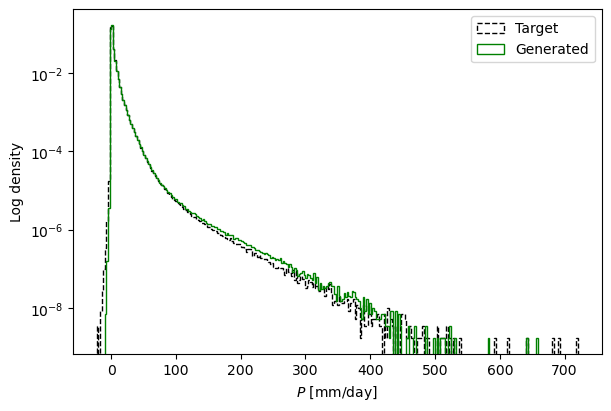

In [11]:
fig, ax = plot_time_mean_histogram(
    precip_hist_ds, figsize=(6, 4), log=True, density=True, histtype="step"
)
# ax.set_title("Precipitation")
ax.set_xlabel(f"{all_vars[PRECIP]} [{da_precip.units}]")
ax.set_ylabel("Log density")
plt.legend()
fig.show()

In [12]:
fig.savefig(os.path.join(OUTDIR, "precip_density.pdf"), bbox_inches="tight")

## Figure 2

In [13]:
%%time

da_wk = da_precip.isel(sample=0)
spectra = compute_wavenumber_frequency_spectra(
    da_wk, 
    segment_size=WK_SEG_SIZE, 
    latitude_bounds=WK_LAT_BOUNDS
)
spectra

INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 3650, 'lat': 30, 'lon': 360})
INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (52, 30, 360, 128)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 0054-05-17 00:00:00 ... 0063-11-16 00:00:00
  * lat         (lat) float32 14.46 13.46 12.47 11.47 ... -12.47 -13.46 -14.46
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.007812 0.01562 ... -0.01562 -0.007812


(52, 30, 361, 129)
freq size is (129,).


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (52, 30, 360, 128)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 0054-05-17 00:00:00 ... 0063-11-16 00:00:00
  * lat         (lat) float32 14.46 13.46 12.47 11.47 ... -12.47 -13.46 -14.46
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.007812 0.01562 ... -0.01562 -0.007812


(52, 30, 361, 129)
freq size is (129,).

Metadata for spectral power components is:
('component', 'wavenumber', 'frequency')
Coordinates:
  * wavenumber  (wavenumber) int64 -180 -179 -178 -177 -176 ... 177 178 179 180
  * frequency   (frequency) float64 -0.5 -0.4922 -0.4844 ... 0.4844 0.4922 0.5
  * component   (component) <U13 'total' 'symmetric' 'antisymmetric'
{}

From smoothFrq121:  Frequency smoothing 1 times for subset of wavenumbers (pos frqs only)

Smoothing background spectrum in wavenumber (pos frq only)...
  Wavenumber smoothing 5 times for freq: 0.0078125
  Wavenumber smoothing 5 times for freq: 0.015625
  Wavenumber smoothing 5 times for freq: 0.0234375
  Wavenumber smoothing 5 times for freq: 0.03125
  Wavenumber smoothing 5 times for freq: 0.0390625
  Wavenumber smoothing 5 times for freq: 0.046875
  Wavenumber smoothing 5 times for freq: 0.0546875
  Wavenumber smoothing 5 times for freq: 0.0625
  Wavenumber smoothing 5 times for freq: 0.0703125
  Wavenumber smoothing 5 

INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 3650, 'lat': 30, 'lon': 360})


Frequency smoothing 10 times for all wavenumbers (pos frqs only)


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (52, 30, 360, 128)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 0054-05-17 00:00:00 ... 0063-11-16 00:00:00
  * lat         (lat) float32 14.46 13.46 12.47 11.47 ... -12.47 -13.46 -14.46
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.007812 0.01562 ... -0.01562 -0.007812


(52, 30, 361, 129)
freq size is (129,).


INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (52, 30, 360, 128)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 0054-05-17 00:00:00 ... 0063-11-16 00:00:00
  * lat         (lat) float32 14.46 13.46 12.47 11.47 ... -12.47 -13.46 -14.46
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.007812 0.01562 ... -0.01562 -0.007812


(52, 30, 361, 129)
freq size is (129,).

Metadata for spectral power components is:
('component', 'wavenumber', 'frequency')
Coordinates:
  * wavenumber  (wavenumber) int64 -180 -179 -178 -177 -176 ... 177 178 179 180
  * frequency   (frequency) float64 -0.5 -0.4922 -0.4844 ... 0.4844 0.4922 0.5
  * component   (component) <U13 'total' 'symmetric' 'antisymmetric'
{}

From smoothFrq121:  Frequency smoothing 1 times for subset of wavenumbers (pos frqs only)

Smoothing background spectrum in wavenumber (pos frq only)...
  Wavenumber smoothing 5 times for freq: 0.0078125
  Wavenumber smoothing 5 times for freq: 0.015625
  Wavenumber smoothing 5 times for freq: 0.0234375
  Wavenumber smoothing 5 times for freq: 0.03125
  Wavenumber smoothing 5 times for freq: 0.0390625
  Wavenumber smoothing 5 times for freq: 0.046875
  Wavenumber smoothing 5 times for freq: 0.0546875
  Wavenumber smoothing 5 times for freq: 0.0625
  Wavenumber smoothing 5 times for freq: 0.0703125
  Wavenumber smoothing 5 

<xarray.Dataset>
Dimensions:     (wavenumber: 361, frequency: 129, component: 4, source: 2)
Coordinates:
  * wavenumber  (wavenumber) int64 -180 -179 -178 -177 -176 ... 177 178 179 180
  * frequency   (frequency) float64 -0.5 -0.4922 -0.4844 ... 0.4844 0.4922 0.5
  * component   (component) <U13 'total' 'symmetric' ... 'background'
    init        object 0054-01-01 00:00:00
  * source      (source) <U10 'target' 'prediction'
Data variables:
    spectrum    (source, component, wavenumber, frequency) float64 0.0 ... 8....

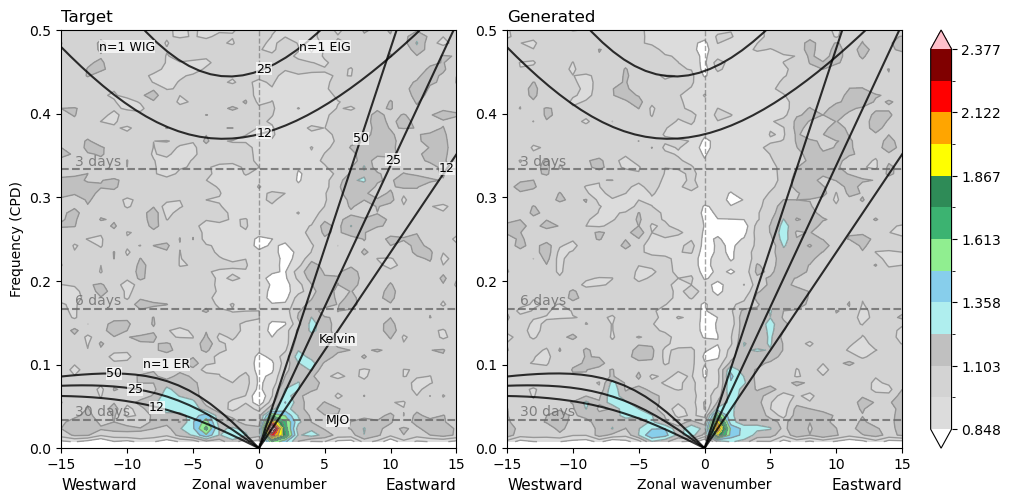

In [14]:
fig, axs = plot_wavenumber_frequency_spectra(
    spectra, 
    component="symmetric",
    figsize=(10, 5),
    plot_error=False,
)
fig.suptitle("")
fig.show()

In [15]:
fig.savefig(os.path.join(OUTDIR, "wk.pdf"), bbox_inches="tight")

## Figure 3

In [16]:
time_mean_bias = compute_time_mean_bias(
    da_precip.sel(source="prediction"),
    da_precip.sel(source="target")
)

In [17]:
ref_da_precip = UNIT_CONVERSIONS[PRECIP](ref_ds[PRECIP])

with ProgressBar():
    ref_da_precip = ref_da_precip.resample(time="1D").mean("time").compute()

ref_time_mean_bias = compute_time_mean_bias(
    ref_da_precip,
    da_precip.sel(source="target"),
)

[########################################] | 100% Completed |  1min 30.4s


Time-mean bias minimum: -2.1789
Time-mean bias maximum: 3.4484


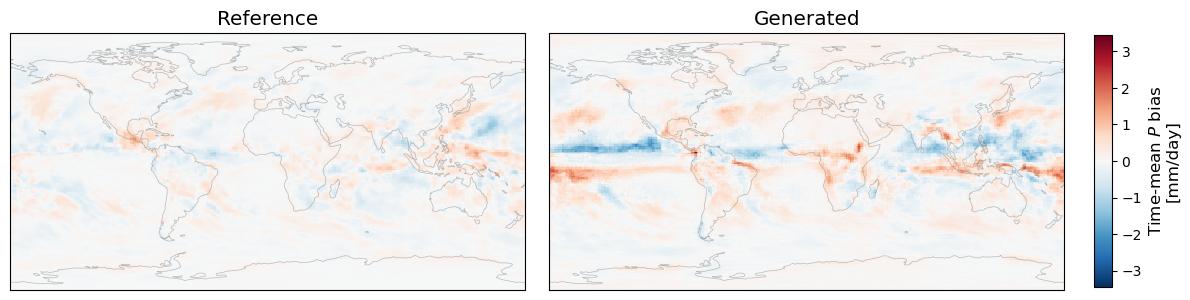

In [18]:
fig, axs = plot_time_mean_bias(
    time_mean_bias, 
    ref_time_mean_bias,
    var_name=all_vars[PRECIP],
    figsize=(12, 3),
    verbose=True,
)
fig.show()

In [19]:
fig.savefig(os.path.join(OUTDIR, "precip_bias.pdf"), bbox_inches="tight")

## Figure 4

In [20]:
da_OLR = ds[OLR].assign_attrs(units=FLUX_UNITS)

time_mean_bias_OLR = compute_time_mean_bias(
    da_OLR.sel(source="prediction"),
    da_OLR.sel(source="target")
)

[########################################] | 100% Completed | 24.1s


In [21]:
ref_da_OLR = ref_ds[OLR].assign_attrs(units=FLUX_UNITS)
ref_time_mean_bias_OLR = compute_time_mean_bias(
    ref_da_OLR,
    da_OLR.sel(source="target")
)

[########################################] | 100% Completed | 27.1s


In [22]:
da_OSR = ds[OSR].assign_attrs(units=FLUX_UNITS)
time_mean_bias_OSR = compute_time_mean_bias(
    da_OSR.sel(source="prediction"),
    da_OSR.sel(source="target")
)

[########################################] | 100% Completed | 48.2s


In [23]:
ref_da_OSR = ref_ds[OSR].assign_attrs(units=FLUX_UNITS)
ref_time_mean_bias_OSR = compute_time_mean_bias(
    ref_da_OSR,
    da_OSR.sel(source="target")
)

[########################################] | 100% Completed |  1min  3.8s


Time-mean $USW_{toa}$ bias minimum: -20.3834
Time-mean $USW_{toa}$ bias maximum: 15.8979
Time-mean $ULW_{toa}$ bias minimum: -14.6901
Time-mean $ULW_{toa}$ bias maximum: 12.5128


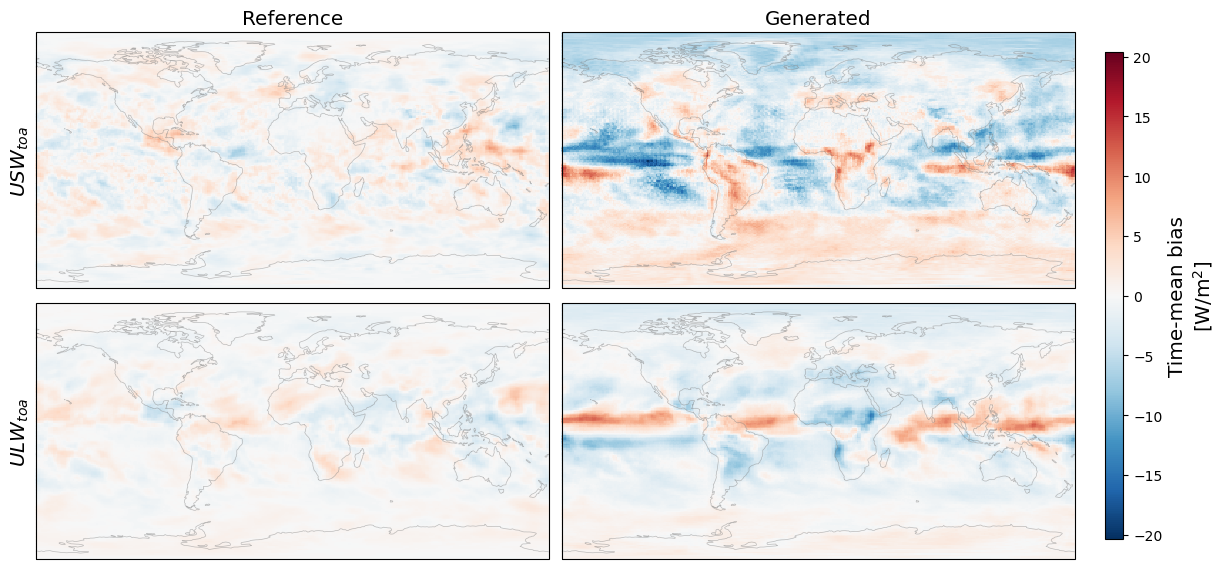

In [24]:
fig, axs = plot_time_mean_bias_list(
    [time_mean_bias_OSR, time_mean_bias_OLR], 
    [ref_time_mean_bias_OSR, ref_time_mean_bias_OLR],
    var_names=[all_vars[OSR], all_vars[OLR]],
    figsize=(12, 5.8),
    verbose=True,
)
fig.show()

In [25]:
fig.savefig(os.path.join(OUTDIR, "osr_olr_bias.pdf"), bbox_inches="tight")

## Figure 3 (alternative combined version of Fig 3 + 4)

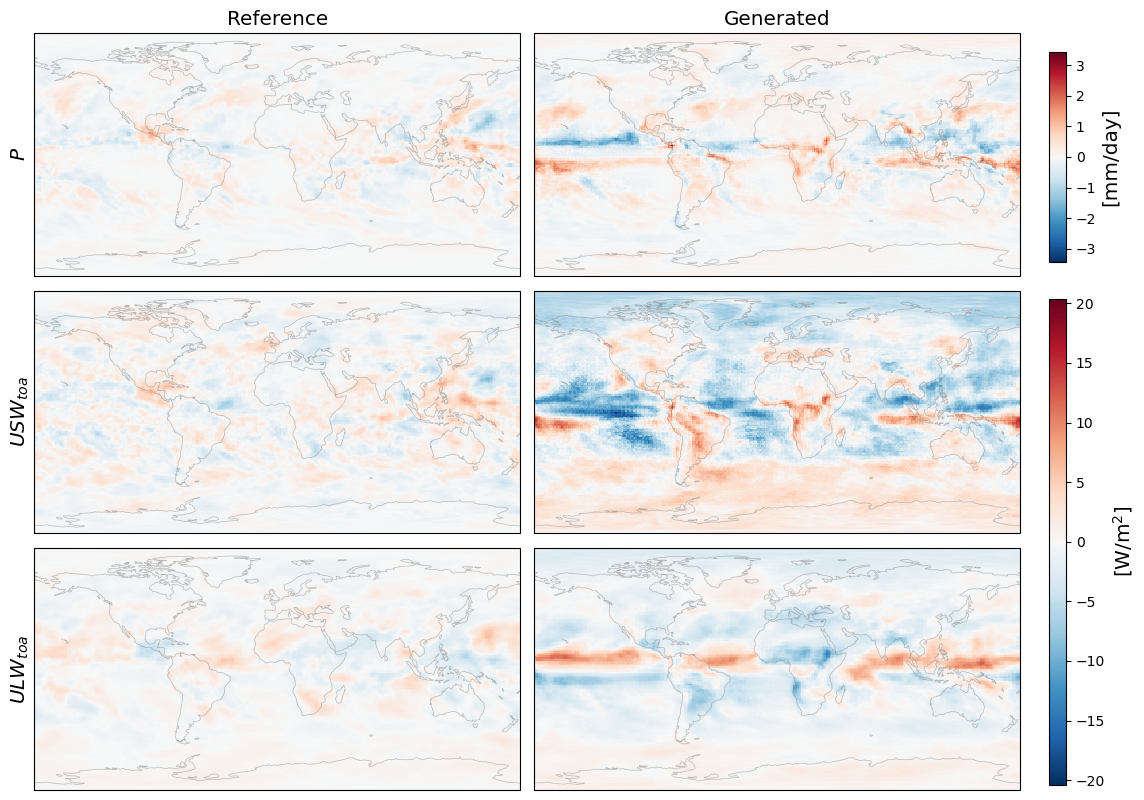

In [26]:
fig, axs = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(11.5, 8.1),
    subplot_kw={"projection": ccrs.PlateCarree()},
)

im_precip = plot_time_mean_bias_list(
    [time_mean_bias],
    [ref_time_mean_bias],
    var_names=[all_vars[PRECIP]],
    axs=axs[0:1]
)

im_fluxes = plot_time_mean_bias_list(
    [time_mean_bias_OSR, time_mean_bias_OLR], 
    [ref_time_mean_bias_OSR, ref_time_mean_bias_OLR],
    var_names=[all_vars[OSR], all_vars[OLR]],
    axs=axs[1:]
)

axs[1][0].set_title("")
axs[1][1].set_title("")

plt.tight_layout()
fig.subplots_adjust(right=0.9)

cbar_ax = fig.add_axes([0.91, 0.67, 0.015, 0.26])
cbar = fig.colorbar(
    im_precip,
    cax=cbar_ax,
    orientation="vertical",
)
cbar.set_label(
    f"[{time_mean_bias.units}]", fontsize="x-large"
)

cbar_ax = fig.add_axes([0.91, 0.025, 0.015, 0.6])
cbar = fig.colorbar(
    im_fluxes,
    cax=cbar_ax,
    orientation="vertical",
)
cbar.set_label(
    f"[{time_mean_bias_OSR.units}]", fontsize="x-large"
)

fig.show()

In [27]:
fig.savefig(os.path.join(OUTDIR, "bias_maps.pdf"), bbox_inches="tight")

## Supplemental Figure 1

In [28]:
all_units = {varname: ds[varname].units for varname in all_vars.keys()}
all_units[PRECIP] = PRECIP_UNITS
all_units[TWP_ADV] = PRECIP_UNITS
all_units[PS] = PS_UNITS

for k, v in all_units.items():
    if v == "W/m2":
        all_units[k] = FLUX_UNITS
        
all_units = pd.DataFrame.from_dict(all_units, orient="index", columns=["units"])

In [29]:
api = wandb.Api()

In [30]:
inf_run = api.run(get_wandb_path(config, RUN_KEY))
ref_inf_run = api.run(get_wandb_path(config, REF_KEY))
fv3gfs_inf_run = api.run(get_wandb_path(config, FV3GFS_KEY))

Bias

In [31]:
inf_bias = load_global_time_mean_metrics(
    wandb_run=inf_run, 
    keys_stem=wandb_inf_keys_stems["bias"],
    vars_dict=all_vars, 
    run_label="ACE-E3SMv2",
    apply_funcs=UNIT_CONVERSIONS,
)

ref_inf_bias = load_global_time_mean_metrics(
    wandb_run=ref_inf_run, 
    keys_stem=wandb_inf_keys_stems["bias"],
    vars_dict=all_vars,
    run_label="Reference",
    apply_funcs=UNIT_CONVERSIONS,
)

fv3gfs_inf_bias = load_global_time_mean_metrics(
    wandb_run=fv3gfs_inf_run, 
    keys_stem=wandb_inf_keys_stems["bias"],
    vars_dict=fv3gfs_vars_dict,
    run_label="ACE-FV3GFS",
    apply_funcs=FV3GFS_CONVERSIONS,
)
fv3gfs_inf_bias.index = inf_bias.index

inf_bias_df = inf_bias.join([
    fv3gfs_inf_bias.drop("label", axis=1),
    ref_inf_bias.drop("label", axis=1)
])
inf_bias_df[["ACE-E3SMv2", "ACE-FV3GFS", "Reference"]]

,ACE-E3SMv2,ACE-FV3GFS,Reference
PS,-2.702467e-01,-2.765151e-01,4.541708e-04
U_0,3.194138e-01,-1.231081e+00,-2.078110e-02
U_1,2.164114e-01,-1.107187e+00,6.928731e-02
U_2,5.032936e-01,-5.108217e-01,3.038932e-02
U_3,8.784131e-02,-4.397714e-01,1.913289e-02
U_4,-5.011198e-02,-3.547679e-01,8.963352e-03
U_5,-7.035805e-02,-1.624823e-01,4.561521e-03
U_6,1.724294e-02,6.794753e-03,-7.418378e-03
U_7,3.543223e-02,5.982321e-02,-7.000032e-03
V_0,1.334578e-03,-2.906681e-02,2.880184e-04


RMSE

In [32]:
inf_rmse = load_global_time_mean_metrics(
    wandb_run=inf_run, 
    keys_stem=wandb_inf_keys_stems["rmse"],
    vars_dict=all_vars, 
    run_label="ACE-E3SMv2",
    apply_funcs=UNIT_CONVERSIONS,
)

ref_inf_rmse = load_global_time_mean_metrics(
    wandb_run=ref_inf_run, 
    keys_stem=wandb_inf_keys_stems["rmse"],
    vars_dict=all_vars,
    run_label="Reference",
    apply_funcs=UNIT_CONVERSIONS,
)

fv3gfs_inf_rmse = load_global_time_mean_metrics(
    wandb_run=fv3gfs_inf_run, 
    keys_stem=wandb_inf_keys_stems["rmse"],
    vars_dict=fv3gfs_vars_dict,
    run_label="ACE-FV3GFS",
    apply_funcs=FV3GFS_CONVERSIONS,
)
fv3gfs_inf_rmse.index = inf_rmse.index

inf_rmse_df = inf_rmse.join([
    fv3gfs_inf_rmse.drop("label", axis=1), 
    ref_inf_rmse.drop("label", axis=1), 
    all_units
])
inf_rmse_df[["ACE-E3SMv2", "ACE-FV3GFS", "Reference"]]

,ACE-E3SMv2,ACE-FV3GFS,Reference
PS,1.077222e+00,9.339790e-01,4.057131e-01
U_0,1.754835e+00,1.957258e+00,4.770657e-01
U_1,1.194368e+00,2.181395e+00,4.218268e-01
U_2,1.656296e+00,1.969008e+00,5.794182e-01
U_3,1.183559e+00,1.473894e+00,5.360406e-01
U_4,8.704611e-01,1.012276e+00,4.251361e-01
U_5,7.114874e-01,8.534608e-01,3.491294e-01
U_6,6.400629e-01,6.803480e-01,3.029726e-01
U_7,5.625350e-01,5.636822e-01,2.699280e-01
V_0,3.341303e-01,4.040133e-01,2.293321e-01


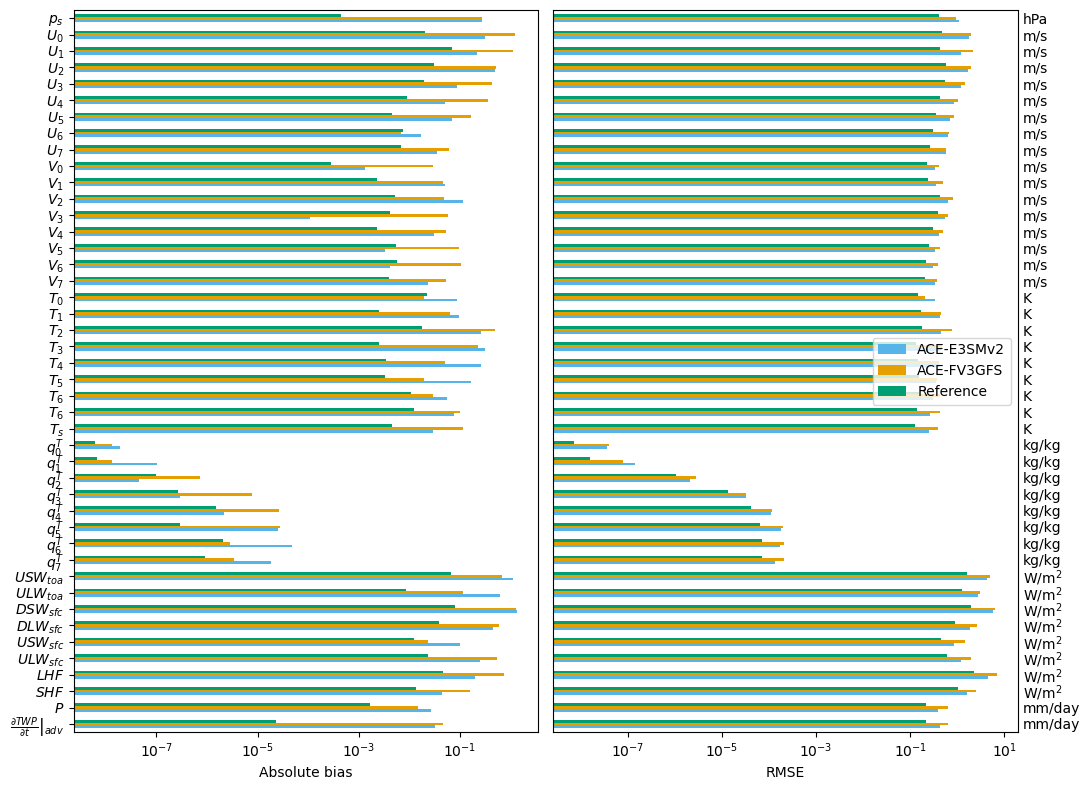

In [33]:
order = list(all_vars.keys())[::-1]

abs_bias_ordered = np.abs(inf_bias_df.loc[order].set_index("label"))
rmse_ordered = inf_rmse_df.loc[order]

fig, axs = plt.subplots(1, 2, figsize=(11, 8))
abs_bias_ordered.plot.barh(ax=axs[0], logx=True, legend=False)
rmse_ordered.plot.barh(ax=axs[1], logx=True)
axs[0].set_xlabel('Absolute bias')
axs[0].set_ylabel('')
axs[1].set_xlabel('RMSE')
axs[1].yaxis.set_tick_params(labelleft=False, labelright=True, length=0.0)
axs[1].set_yticklabels(rmse_ordered["units"])
plt.tight_layout()

In [34]:
fig.savefig(os.path.join(OUTDIR, "global_time_means.pdf"), bbox_inches="tight")

## Supplemental Figure 2

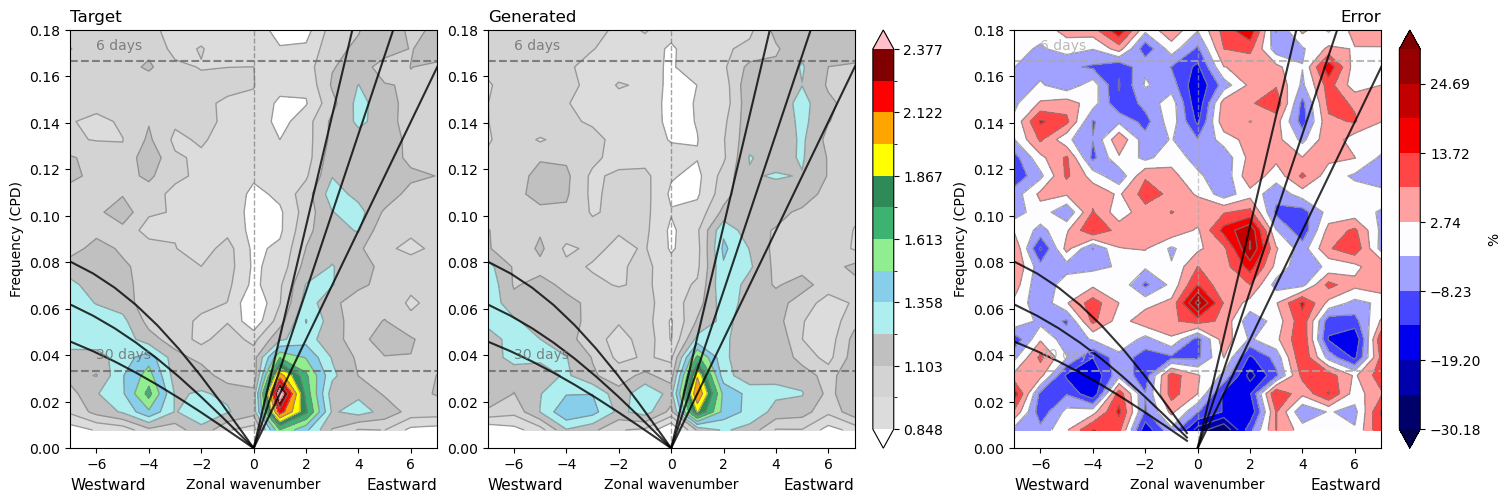

In [35]:
fig, axs = plot_wavenumber_frequency_spectra(
    spectra, 
    component="symmetric",
    figsize=(15, 5),
    plot_error=True,
    mjo_zoom=True,
)
fig.suptitle("")
fig.show()

In [36]:
fig.savefig(os.path.join(OUTDIR, "wk_zoom.pdf"), bbox_inches="tight")